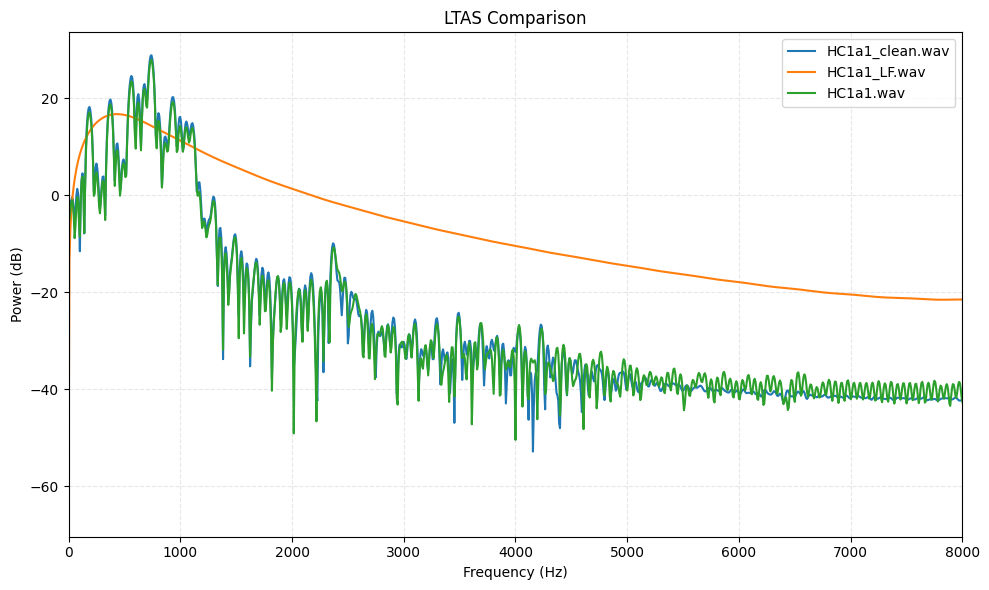

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 이미 정의된 read_wav_any() 사용한다고 가정
def read_wav_any(path: str):
    """WAV 파일 읽기 (scipy 우선, 실패 시 soundfile).
    반환: (waveform [float32, mono], sr)
    """
    path = str(path)
    # 1) scipy
    try:
        from scipy.io import wavfile
        sr, y = wavfile.read(path)
        if y.ndim == 2:  # 스테레오 → 모노
            y = y.mean(axis=1)
        if np.issubdtype(y.dtype, np.integer):
            y = y.astype(np.float32) / np.iinfo(y.dtype).max
        else:
            y = y.astype(np.float32)
        return y, int(sr)
    except Exception as e_scipy:
        # 2) soundfile
        try:
            import soundfile as sf
            y, sr = sf.read(path, dtype="float32", always_2d=False)
            if y.ndim == 2:
                y = y.mean(axis=1)
            return y.astype(np.float32), int(sr)
        except Exception as e_sf:
            raise RuntimeError(f"Failed to read WAV file '{path}': {e_scipy} / {e_sf}")
        
def plot_ltas_compare(files, base_dir, sr_target=16000, nfft=2048, dpi=300):
    plt.figure(figsize=(10,6))
    for f in files:
        path = Path(base_dir)/f
        y, sr = read_wav_any(path)
        # 모노 정규화
        y = y / (np.max(np.abs(y)) + 1e-9)
        # 리샘플 필요시
        if sr != sr_target:
            y = np.interp(
                np.linspace(0, 1, int(len(y) * sr_target / sr), endpoint=False),
                np.linspace(0, 1, len(y), endpoint=False),
                y
            )
            sr = sr_target

        # FFT 기반 파워 스펙트럼
        spec = np.fft.rfft(y, n=nfft)
        mag = np.abs(spec)**2
        freqs = np.fft.rfftfreq(nfft, 1/sr)
        Pdb = 10*np.log10(mag + 1e-12)

        plt.plot(freqs, Pdb, label=f)

    plt.title("LTAS Comparison")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.xlim(0, sr_target/2)   # Nyquist 까지
    plt.legend()
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    plt.savefig("ltas_comparison.png", dpi=dpi, bbox_inches="tight")
    plt.show()

# 사용 예시
base_dir = "C:/Users/user/Desktop/parkinsons/DATA/records"  # 파일 경로 맞게 수정
files = ["HC1a1_clean.wav", "HC1a1_LF.wav", "HC1a1.wav"]
plot_ltas_compare(files, base_dir)


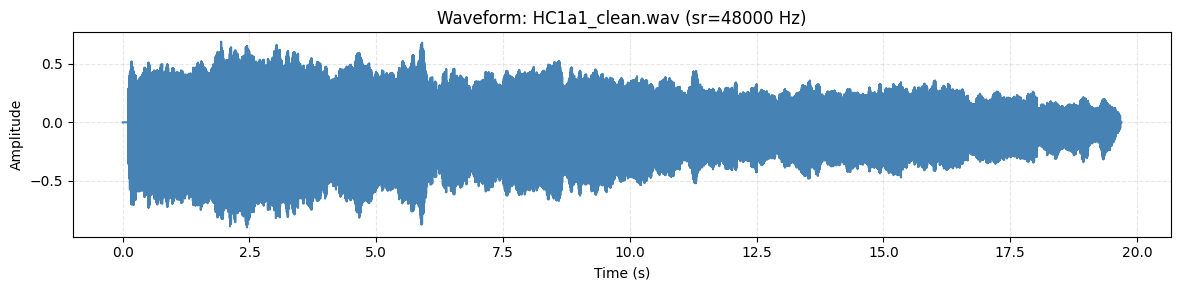

[OK] 저장: HC1a1_clean_waveform.png


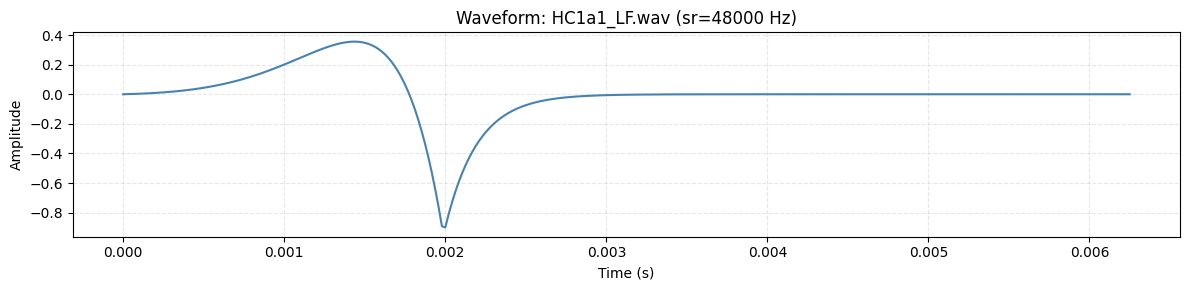

[OK] 저장: HC1a1_LF_waveform.png


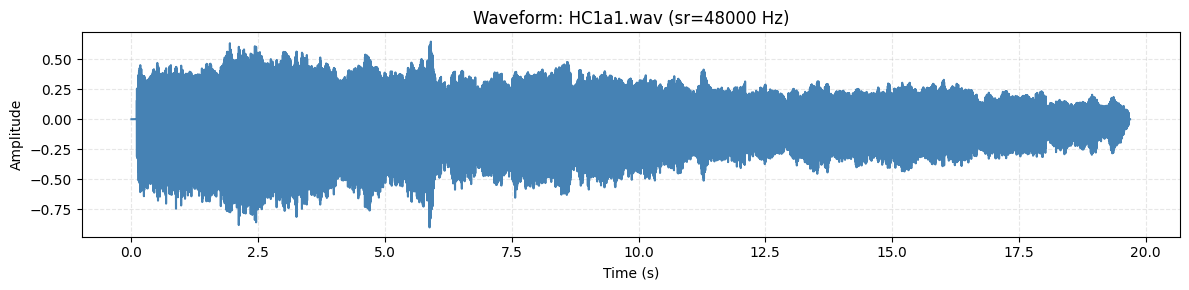

[OK] 저장: HC1a1_waveform.png


In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile

def read_wav_simple(path: str):
    """간단 WAV 로더 (mono 변환 + float32 정규화)."""
    sr, y = wavfile.read(path)
    if y.ndim == 2:  # 스테레오 → 모노
        y = y.mean(axis=1)
    if np.issubdtype(y.dtype, np.integer):
        y = y.astype(np.float32) / np.iinfo(y.dtype).max
    else:
        y = y.astype(np.float32)
    return y, sr

def plot_waveform(path: str, dpi: int = 300):
    y, sr = read_wav_simple(path)
    t = np.arange(len(y)) / sr
    plt.figure(figsize=(12, 3))
    plt.plot(t, y, color="steelblue")
    plt.title(f"Waveform: {Path(path).name} (sr={sr} Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    out_path = f"{Path(path).stem}_waveform.png"
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"[OK] 저장: {out_path}")

# 사용 예시
base_dir = "C:/Users/user/Desktop/parkinsons/DATA/records"
files = ["HC1a1_clean.wav", "HC1a1_LF.wav", "HC1a1.wav"]

for fname in files:
    fpath = os.path.join(base_dir, fname)
    plot_waveform(fpath, dpi=320)
